In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import sys

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
fold = 1

In [2]:
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    return unique_list
      

In [19]:

def plot_pretty_blue_confusion_matrix(classes, y_true=[], y_pred=[], cm=[],
                                      normalize=False,
                                      title=None,
                                      cmap=plt.cm.Blues,
                                      savepath=None,
                                      figsize=(24,24)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'
    labels=list(range(0,len(classes),1))
    # Compute confusion matrix
    if (len(y_true)==0 and len(y_pred)==0) and len(cm)==0:
        sys.exit('need at least cm or the predictions and truths')
    elif len(cm)==0:
        cm = confusion_matrix(y_true, y_pred,labels=labels)
    #     precisions = np.diag(cm) / np.sum(cm, axis = 0)
    #     recalls = np.diag(cm) / np.sum(cm, axis = 1)
    #     print("Precision: ", np.round(precisions, 4))
    #     print("Recall: ", np.round(recalls, 4))

        # Only use the labels that appear in the data
    #     classes = classes[unique_labels(y_true, y_pred)]
        
#     print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        acc = 0
        num=len(classes)
        for i in range(len(classes)):
            if math.isnan(cm[i][i]):
                num = num-1
                continue
            acc += cm[i][i]
        acc = acc/num
        print('Avg Acc',acc)
    else:
        print("Confusion matrix")

#     print(cm.shape)
#     print(len(classes))
    save_df = pd.DataFrame(data=cm, columns=classes)
    save_df.index = classes
    save_df.to_csv(savepath+'.csv', index=True)

    fig, ax = plt.subplots(figsize=figsize)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # ax.tick_params(direction='out', length=6, width=2, colors='r',
    #            grid_color='r', grid_alpha=0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.25)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            if math.isnan(val):
                val = 0.0
            ax.text(j, i, format(val, fmt),
                    ha="center", va="center", size=6,
                    color="white" if cm[i, j] > thresh else "black")
    if savepath is not None:
        fig.savefig(savepath + '.jpg',dpi=150)
    plt.close()
    return ax, acc

In [43]:
FOLDS=[1,2,3,4,5]
SEEDS=[0,1,2,3,4]
np.zeros(24)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [47]:
accA=np.zeros(25)
accB=np.zeros(25)
accC=np.zeros(25)
accD=np.zeros(25)
iters=0
for fold in FOLDS:
    probas = pd.read_csv('closed/fold{}/xception_probabilities.csv'.format(fold))
    probas_columns = list(range(1,17,1))
    OGpd = pd.read_csv('datasplits/split_fold{}.csv'.format(fold))
    
    # first get the species list
    species_list = ['']*17
    for i in range(OGpd.shape[0]):
        tmp_sp = OGpd['Species_Name'][i]
        if 'spp' not in tmp_sp and tmp_sp!='mosquito' :
            if tmp_sp not in species_list:
    #             print(species_list[15])
                species_list[OGpd['Species'][i]]=tmp_sp.split('_')[0] + ' ' + tmp_sp.split('_')[1]
        else:
            tmp_sp = 'Unknown'
            if tmp_sp not in species_list:
                species_list[16]=tmp_sp
                
    for seed in SEEDS:
        xslx_fname = 'closed/results_fold{}_seed{}.csv'.format(fold,seed)
        preppedpd = pd.read_csv(xslx_fname)

        #newpd = pd.DataFrame(preppedpd.copy)
        species_pred_column = []
        species_itruth_column = []
        species_ipred_column = []
        just_known_ipred=[]
        just_known_itruth=[]
        for i in range(preppedpd.shape[0]):
            if preppedpd['U-K Truth'][i]=='Unknown':
                species_itruth_column.append(16)
            elif preppedpd['U-K Truth'][i]=='Known':
                species_itruth_column.append(int(species_list.index(preppedpd['Species Truth'][i].replace('_sl',''))))
            if preppedpd['U-K Pred'][i]=='Unknown':
                species_pred_column.append('')
                species_ipred_column.append(16)
            elif preppedpd['U-K Pred'][i]=='Known':
                idx = probas[probas['Id']==preppedpd['Id'][i]].index.values[0]
                probas_tmp = probas.iloc[idx,probas_columns].to_list()
                pred_i = probas_tmp.index(max(probas_tmp))
                pred = species_list[pred_i]
                species_ipred_column.append(int(pred_i))
                species_pred_column.append(pred)
                just_known_ipred.append(pred_i)
                just_known_itruth.append(species_itruth_column[i])
            else:
                print(i)
        unique(species_itruth_column)
        
        preppedpd['Species Pred'] = species_pred_column
        preppedpd['Species Truth idx'] = species_itruth_column
        preppedpd['Species Pred idx'] = species_ipred_column
        accA[iters] = len(preppedpd[preppedpd['Species Truth idx'] ==preppedpd['Species Pred idx']])/len(preppedpd['Species Truth idx'])
        preppedpd.to_csv(xslx_fname.replace('closed','cascaded'))
        acc = 0
        for i in range(len(just_known_ipred)):
            if just_known_ipred[i]==just_known_itruth[i]:
                acc+=1
#             else:
#                 print(just_known_ipred[i],just_known_itruth[i])
        accC[iters]=acc/len(just_known_ipred) #cascaded known only unweighted
        
        _,acc=plot_pretty_blue_confusion_matrix(classes=species_list,
                                  y_true=preppedpd['Species Truth idx'], 
                                  y_pred=preppedpd['Species Pred idx'], 
                                  normalize=True,  
                                  savepath='cascaded/confusion_fold{}seed{}'.format(fold,seed),
                                  figsize=(12,12))
        accB[iters]=acc
        _,acc=plot_pretty_blue_confusion_matrix(classes=species_list,
                                  y_true=just_known_itruth, 
                                  y_pred=just_known_ipred, 
                                  normalize=True,  
                                  savepath='cascaded/confusion_fold{}seed{}_known'.format(fold,seed),
                                  figsize=(12,12))
        accD[iters]=acc #cascaded known only species normalized

        iters+=1
# avg_accA=avg_accA/iters
# avg_accB=avg_accB/iters
# avg_accC=avg_accC/iters
# avg_accD=avg_accD/iters
# # preppedpd

Normalized confusion matrix
Avg Acc 0.7831165754783974


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.90585746170246
Normalized confusion matrix
Avg Acc 0.7791673877151604


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.9217596938353819
Normalized confusion matrix
Avg Acc 0.7710798298501855


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.9178966439704622
Normalized confusion matrix
Avg Acc 0.7684957199115929


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.9169754055468341
Normalized confusion matrix
Avg Acc 0.7519470149478421
Normalized confusion matrix
Avg Acc 0.8674715190045668


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.6995188352756033
Normalized confusion matrix
Avg Acc 0.9204081632653062


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.6959841698767657
Normalized confusion matrix
Avg Acc 0.9211957057999329


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.7129897524661003
Normalized confusion matrix
Avg Acc 0.9207733093237296


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.7414520240795798
Normalized confusion matrix
Avg Acc 0.926035931614025


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.770502242601129
Normalized confusion matrix
Avg Acc 0.9262545556490047
Normalized confusion matrix
Avg Acc 0.7373310679841072


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.9375
Normalized confusion matrix
Avg Acc 0.7431255202126184


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.9375
Normalized confusion matrix
Avg Acc 0.7813143918947384
Normalized confusion matrix
Avg Acc 0.9411764705882353
Normalized confusion matrix
Avg Acc 0.7721285257256506


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.9375
Normalized confusion matrix
Avg Acc 0.7823655195200752


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.9375
Normalized confusion matrix
Avg Acc 0.7914531185299698


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.8939950980392157
Normalized confusion matrix
Avg Acc 0.7887106029744357


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.8946314102564102
Normalized confusion matrix
Avg Acc 0.7728800707835762


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.8939950980392157
Normalized confusion matrix
Avg Acc 0.7799075711671969


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.8948717948717949
Normalized confusion matrix
Avg Acc 0.8085633164748083
Normalized confusion matrix
Avg Acc 0.8966802937391174
Normalized confusion matrix
Avg Acc 0.7540580847343263


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.9272237196765499
Normalized confusion matrix
Avg Acc 0.7689056146682672


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.9285714285714286
Normalized confusion matrix
Avg Acc 0.7213584408751367


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.9272959183673469
Normalized confusion matrix
Avg Acc 0.7334837830228633


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.9271428571428572
Normalized confusion matrix
Avg Acc 0.6701903192399169


<ipython-input-19-f5d6763e2d69>:32: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
Avg Acc 0.9173160173160173


In [48]:
# print(accA)
avg_accA=accA.mean()
std_accA=accA.std()
avg_accB=accB.mean()
std_accB=accB.std()
avg_accC=accC.mean()
std_accC=accC.std()
avg_accD=accD.mean()
std_accD=accD.std()
print(avg_accA,std_accA)
print(avg_accB,std_accB)
print(avg_accC,std_accC)
print(avg_accD,std_accD)
# species_list[:16]

[0.88876014 0.86540664 0.86324786 0.85231826 0.86655405 0.93193984
 0.85675    0.85288967 0.92923    0.91570785 0.71847791 0.94412847
 0.91416166 0.91507571 0.7512622  0.8968386  0.91130643 0.91402337
 0.92219241 0.9030837  0.95622896 0.95930479 0.94934014 0.88472059
 0.90635973]
0.8907723604271421 0.05579261249256058
0.7552011800004017 0.0334767078483781
0.7173512913774037 0.16746198325544837
0.9175011398527958 0.017865519657232286


In [6]:
# # first get the species list
# species_list = ['']*17
# for i in range(OGpd.shape[0]):
#     tmp_sp = OGpd['Species_Name'][i]
#     if 'spp' not in tmp_sp and tmp_sp!='mosquito' :
#         if tmp_sp not in species_list:
# #             print(species_list[15])
#             species_list[OGpd['Species'][i]]=tmp_sp.split('_')[0] + ' ' + tmp_sp.split('_')[1]
#     else:
#         tmp_sp = 'Unknown'
#         if tmp_sp not in species_list:
#             species_list[16]=tmp_sp


In [7]:
# probas = pd.read_csv('closed/fold{}/xception_probabilities.csv'.format(fold))
# probas_columns = list(range(1,17,1))



In [8]:
# species_pred_column = []
# species_itruth_column = []
# species_ipred_column = []
# for i in range(preppedpd.shape[0]):
#     if preppedpd['U-K Truth'][i]=='Unknown':
#         species_itruth_column.append(16)
#     elif preppedpd['U-K Truth'][i]=='Known':
#         species_itruth_column.append(int(species_list.index(preppedpd['Species Truth'][i].replace('_sl',''))))
#     if preppedpd['U-K Pred'][i]=='Unknown':
#         species_pred_column.append('')
#         species_ipred_column.append(16)
#     elif preppedpd['U-K Pred'][i]=='Known':
#         idx = probas[probas['Id']==preppedpd['Id'][i]].index.values[0]
#         probas_tmp = probas.iloc[idx,probas_columns].to_list()
#         pred_i = probas_tmp.index(max(probas_tmp))
#         pred = species_list[pred_i]
#         species_ipred_column.append(int(pred_i))
#         species_pred_column.append(pred)
#     else:
#         print(i)
# unique(species_itruth_column)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [11]:
preppedpd['Species Pred'] = species_pred_column
preppedpd['Species Truth idx'] = species_itruth_column
preppedpd['Species Pred idx'] = species_ipred_column

preppedpd.to_csv('full_results_fold{}_seed0.csv'.format(fold))

Normalized confusion matrix
Avg Acc 0.7831165754783974


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

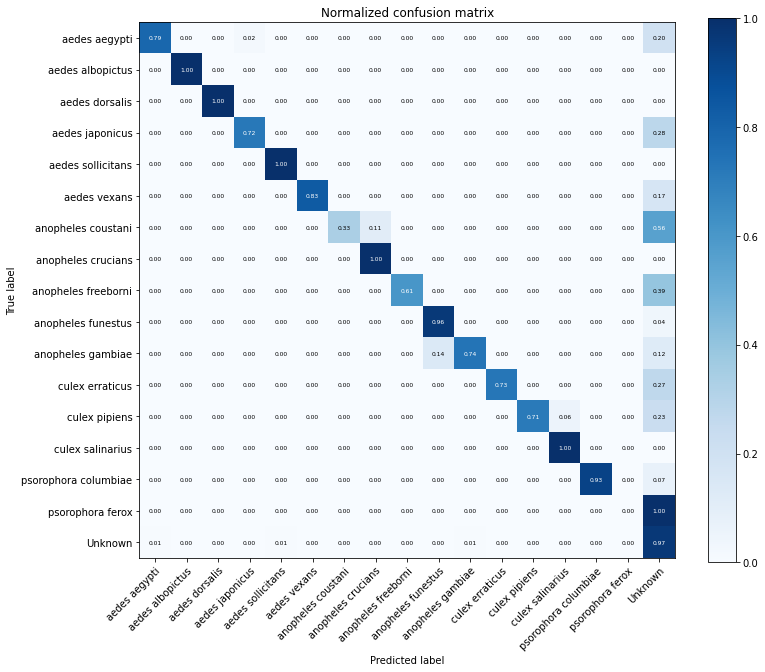

In [12]:
plot_pretty_blue_confusion_matrix(classes=species_list,
                                  y_true=preppedpd['Species Truth idx'], 
                                  y_pred=preppedpd['Species Pred idx'], 
                                  normalize=True,  
                                  savepath='cascaded/confusion_fold{}'.format(fold),
                                  figsize=(12,12))